In [1]:
from binance.client import Client

client = Client()

klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1HOUR, "1 months ago UTC")

In [2]:
import pandas as pd
import pandas_ta as ta

df = pd.DataFrame(klines, 
                 columns = ["open_time","open","high","low","close","vol","close_time","quote_vol",\
                            "trades","taker_base_vol","taker_quote_vol","ignore"])

df = df[["open_time","open","high","low","close"]]

df["open_time"] = pd.to_datetime(df["open_time"], unit = "ms")

df["open"] = df.open.astype(float)
df["high"] = df.high.astype(float)
df["low"] = df.low.astype(float)
df["close"] = df.close.astype(float)

## Take the rolling atr so the yaxis doesn't shake too much 
df["atr"] = ta.atr(high=df.high, low=df.low, close=df.close)
df["atr"] = df.atr.rolling(window=30).mean()


df.set_index("open_time", inplace = True)

df

,open,high,low,close,atr
open_time,,,,,
2022-12-10 13:00:00,1266.64,1273.06,1263.61,1268.04,NaN
2022-12-10 14:00:00,1268.03,1274.23,1266.77,1271.69,NaN
2022-12-10 15:00:00,1271.70,1279.26,1271.10,1278.26,NaN
2022-12-10 16:00:00,1278.26,1283.61,1273.31,1274.21,NaN
2022-12-10 17:00:00,1274.21,1275.77,1266.48,1267.49,NaN
...,...,...,...,...,...
2023-01-10 08:00:00,1323.22,1332.35,1321.70,1328.31,8.446098
2023-01-10 09:00:00,1328.31,1331.96,1326.83,1329.89,8.449710
2023-01-10 10:00:00,1329.90,1334.73,1328.85,1333.77,8.452326


# Plotting Price Data

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from IPython import display
from IPython.display import HTML
pd.set_option('mode.chained_assignment', None)

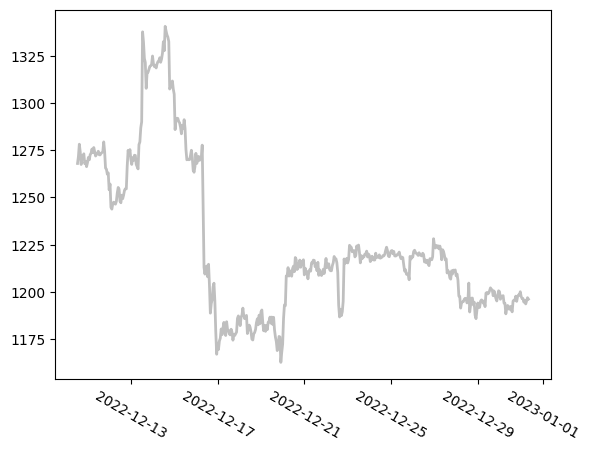

In [4]:
df2 = df.iloc[0:500]

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c='grey', lw=2, alpha=0.5, zorder=5)

plt.show()

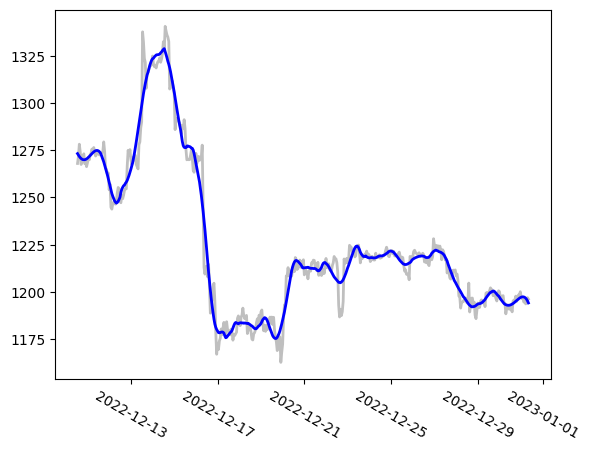

In [5]:
df2 = df.iloc[0:500]

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c='grey', lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c='b', lw=2, zorder=5)

plt.show()

#  Detecting Extrema

[ 21  96 207 242 309 397 460]


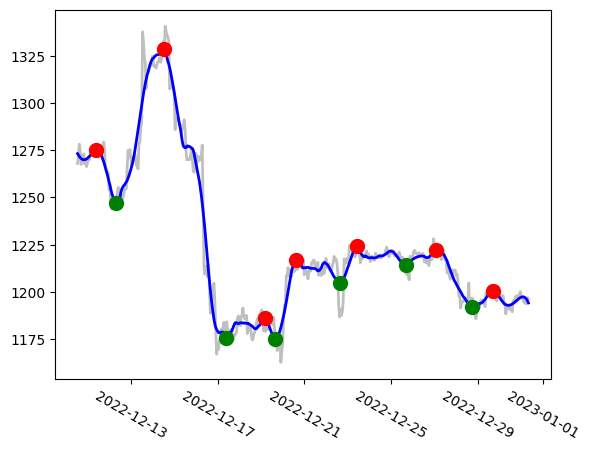

In [6]:
df2 = df.iloc[0:500]

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c='grey', lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c='b', lw=2, zorder=5)

atr = df2.atr.iloc[-1] # all the first atrs are NaN

peaks_idx, _ = find_peaks(df2.close_smooth, distance = 15, 
        width = 3, prominence=atr)

print(peaks_idx)

troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance = 15, 
        width = 3, prominence=atr)

peaks, = ax.plot(df2.index[peaks_idx], df2.close_smooth.iloc[peaks_idx], \
                 c="r", linestyle='None', markersize = 10.0, marker = "o", zorder=10)

troughs, = ax.plot(df2.index[troughs_idx], df2.close_smooth.iloc[troughs_idx], \
                   c="g", linestyle='None', markersize = 10.0, marker = "o", zorder=10)

plt.show()

# Finding Runs

0


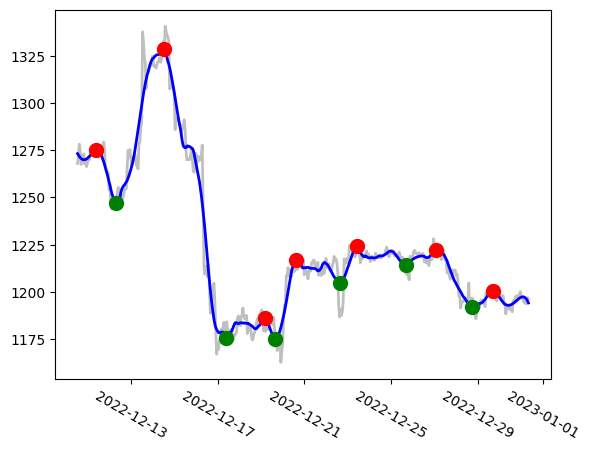

In [7]:
df2 = df.iloc[0:500]

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c='grey', lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c='b', lw=2, zorder=5)

atr = df2.atr.iloc[-1] # all the first atrs are NaN

peaks_idx, _ = find_peaks(df2.close_smooth, distance = 15, 
        width = 3, prominence=atr)

troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance = 15, 
        width = 3, prominence=atr)

peaks, = ax.plot(df2.index[peaks_idx], df2.close_smooth.iloc[peaks_idx], \
                 c="r", linestyle='None', markersize = 10.0, marker = "o", zorder=10)

troughs, = ax.plot(df2.index[troughs_idx], df2.close_smooth.iloc[troughs_idx], \
                   c="g", linestyle='None', markersize = 10.0, marker = "o", zorder=10)


up_run_length = 0
up_run = True
while up_run:
    if 2 + up_run_length > len(peaks_idx) or 2 + up_run_length > len(troughs_idx):
        break
    if df2.close_smooth.iloc[peaks_idx[-1 - up_run_length]] > df2.close_smooth.iloc[peaks_idx[-2 - up_run_length]] and \
       df2.close_smooth.iloc[troughs_idx[-1 - up_run_length]] > df2.close_smooth.iloc[troughs_idx[-2 - up_run_length]]:
        up_run_length += 1
    else:
        up_run = False    
          

if up_run_length > 0:
    ax.set_facecolor((150/255, 255/255, 159/255, 0.3))  
else:
    ax.set_facecolor("white")
        
print(up_run_length)

plt.show()

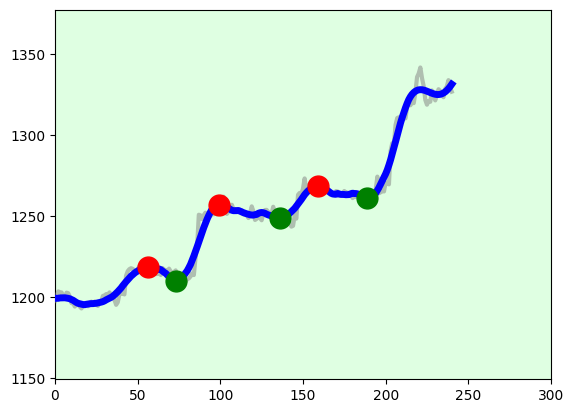

In [8]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

bars_in_frame = 300


fig, ax = plt.subplots()

# increase video quality
#fig, ax = plt.subplots(figsize=(8,8), dpi=300)

price, = ax.plot([], c='grey', lw=3, alpha=0.5, zorder=5)
price_smooth, = ax.plot([], c='b', lw=5, zorder=5)
peaks, = ax.plot([], c="r", linestyle='None', markersize = 15.0, marker = "o", zorder=10)
troughs, = ax.plot([], c="g", linestyle='None', markersize = 15.0, marker = "o", zorder=10)


## Might turn the yaxis off, can be annoying
ax.set_ylim(15000,20000)
ax.set_xlim(0,bars_in_frame)

def animate(frame):
    
    frames_behind = 30

    df2 = df.iloc[-len(df) + frame + 30:frame+bars_in_frame + 30]
    df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

    df2 = df2.iloc[frames_behind:]
    
    x_coords = [x for x in range(len(df2.close_smooth))]
    
    price.set_data((x_coords, df2.close))
    price_smooth.set_data((x_coords, df2.close_smooth))
    
    first_atr = df2.atr.iloc[0]
    
    ax.set_ylim(df2.close_smooth.min() - 10*first_atr, df2.close_smooth.max() + 10*first_atr)
    
    peaks_idx, _ = find_peaks(df2.close_smooth, distance = 15, 
                width = 3, prominence=first_atr)

    troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance = 15, 
                width = 3, prominence=first_atr)
    
    up_run_length = 0
    up_run = True
    while up_run:
        if 2 + up_run_length > len(peaks_idx) or 2 + up_run_length > len(troughs_idx):
            break

        if df2.close_smooth.iloc[peaks_idx[-1 - up_run_length]] >  df2.close_smooth.iloc[peaks_idx[-2 - up_run_length]] and \
           df2.close_smooth.iloc[troughs_idx[-1 - up_run_length]] >  df2.close_smooth.iloc[troughs_idx[-2 - up_run_length]]:
            up_run_length += 1
        else:
            up_run = False

    down_run_length = 0
    down_run = True
    while down_run:
        if 2 + down_run_length > len(peaks_idx) or 2 + down_run_length > len(troughs_idx):
            break
            
        if df2.close_smooth.iloc[peaks_idx[-1 - down_run_length]] <  df2.close_smooth.iloc[peaks_idx[-2 - down_run_length]] and \
           df2.close_smooth.iloc[troughs_idx[-1 - down_run_length]] <  + df2.close_smooth.iloc[troughs_idx[-2 - down_run_length]]:
            down_run_length += 1
        else:
            down_run = False
            
    peaks.set_data((peaks_idx, df2.close_smooth.iloc[peaks_idx]))
    troughs.set_data((troughs_idx, df2.close_smooth.iloc[troughs_idx]))
        
    if up_run_length > 0:
        
        ax.set_facecolor((150/255, 255/255, 159/255, 0.3))
    elif down_run_length > 0:
        ax.set_facecolor((255/255, 150/255, 150/255, 0.3))
    else:
        ax.set_facecolor("white")
    
    return price, price_smooth, peaks, troughs


anim = FuncAnimation(fig, animate, frames=len(df)-bars_in_frame, interval=40, blit=True)
video = HTML(anim.to_html5_video())
display.display(video)

# Saving our animation

In [6]:
with open('video-hd.html', 'w') as f:
    f.write(video.data)